In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image as pil_image
import os
import matplotlib.pyplot as plt
from copy import deepcopy

# Original image

In [46]:
train_img = []
IMG_HEIGHT =512
IMG_WIDTH =512
for img_folder in os.listdir('train_img/'):
    for img_jpg in os.listdir('train_img/'+img_folder):
        img = pil_image.open('train_img/'+img_folder+'/'+img_jpg)
        img = img.resize((IMG_HEIGHT,IMG_WIDTH))
        img = np.array(img)
        #img = img.astype('float32')
        train_img.append(img)


In [56]:
train_img[4].shape

(256, 256, 3)

In [2]:
img = pil_image.open('train_img/81304/000031772.jpg')
img=img.resize((512,512))
img = np.array(img)
img=img/255
img.shape

(512, 512, 3)

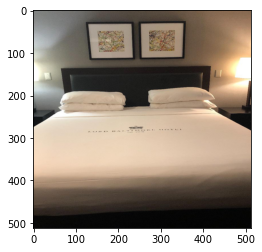

In [3]:
plt.imshow(img)

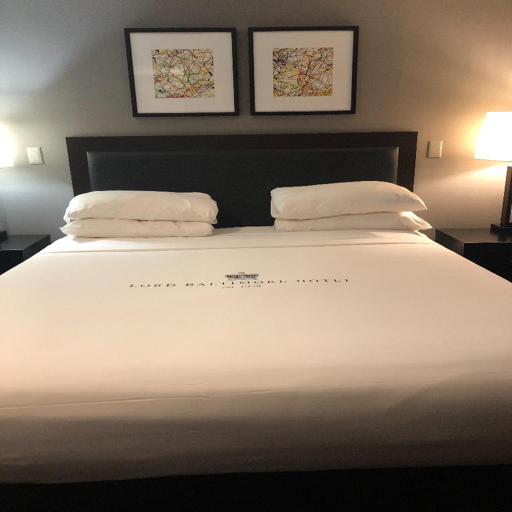

In [44]:
resizeimg =pil_image.fromarray((img*255).astype(np.uint8))
resizeimg

# Mask image

In [2]:
train_masks = []
IMG_HEIGHT =256
IMG_WIDTH =256
#count = 0
for mask in os.listdir('train_masks'):
    img = np.array(pil_image.open('train_masks/'+mask))
    #img = np.resize(img,(IMG_HEIGHT,IMG_WIDTH,3))
    #img = img.astype('float32')
    train_masks.append(img)



In [32]:
imgm = pil_image.open('train_masks/00006.png')
imgm = imgm.convert('RGB')
imgm = imgm.resize((512,512))
imgm = np.array(imgm)
#imgm = imgm[:,:,:3]
imgm.shape


(512, 512, 3)

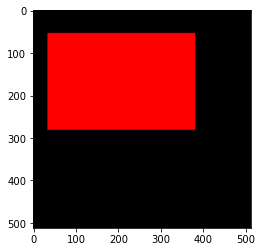

In [33]:
plt.imshow(imgm)

In [34]:
imgm=imgm/255
mask = np.where(imgm[:, :, 0] < 1,1,0)

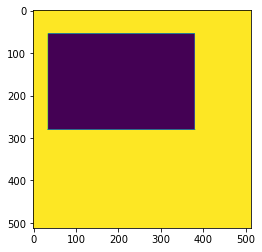

In [50]:
plt.imshow(mask[:,:])

In [51]:
np.unique(mask,return_counts=True)

(array([0, 1]), array([ 77972, 184172]))

In [60]:
R,G,B= (imgm[:,:,0],imgm[:,:,1],imgm[:,:,2])

In [59]:
np.unique(imgm[:,:,0],return_counts=True)

(array([0.        , 0.02352941, 0.03137255, 0.06666667, 0.08235294,
        0.14117647, 0.14509804, 0.15294118, 0.16078431, 0.16470588,
        0.17647059, 0.18039216, 0.18823529, 0.45490196, 0.4627451 ,
        0.46666667, 0.95686275, 0.97254902, 0.97647059, 0.98431373,
        0.99215686, 0.99607843]),
 array([260195,      1,      1,      1,      1,      1,    225,      1,
             1,    346,      1,    225,      1,      1,      1,    345,
             1,    224,      2,    345,    224,      1]))

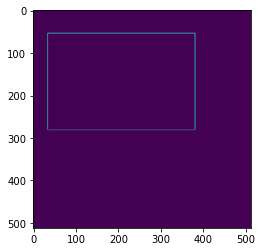

In [61]:
plt.imshow(R)

In [39]:
R[mask==0]=0
B[mask==0]=0
G[mask==0]=0

In [40]:
mask_img = np.stack([R,G,B],-1)

In [41]:
mask_img.shape

(512, 512, 3)

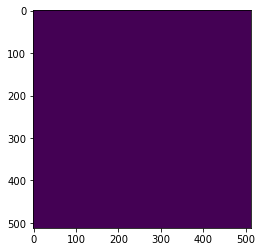

In [46]:
plt.imshow(mask_img[:,:,2])

In [614]:
np.unique(mask_img,return_counts=True)

(array([0.        , 0.02352941, 0.03137255, 0.06666667, 0.08235294,
        0.14117647, 0.14509804, 0.15294118, 0.16078431, 0.16470588,
        0.17647059, 0.18039216, 0.18823529, 0.45490196, 0.4627451 ,
        0.46666667, 0.95686275, 0.97254902, 0.97647059, 0.98431373,
        0.99215686, 0.99607843, 1.        ]),
 array([550567,      1,      1,      1,      1,      1,    225,      1,
             1,    346,      1,    225,      1,      1,      1,    345,
             1,    224,      2,    345,    224,      1, 233916]))

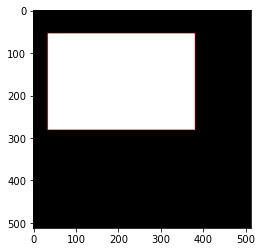

In [621]:
plt.imshow(mask_img[:,:,:])

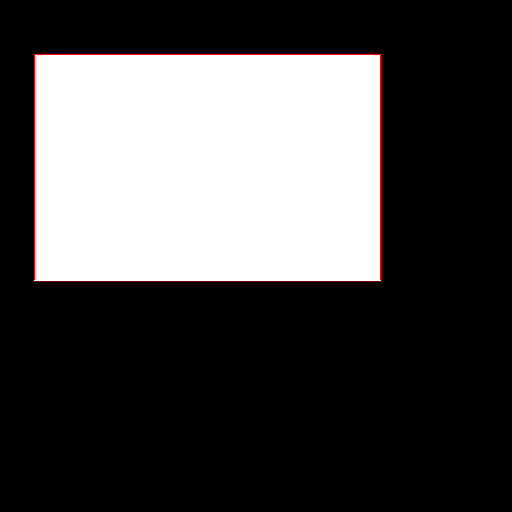

In [622]:
pil_image.fromarray((mask_img*255).astype(np.uint8))

# combine: img+ mask = MASKED_image

In [12]:
#masked_img = deepcopy(img)
masked_img = img.copy()
masked_img[mask==1] = 1

In [642]:
#np.unique(img,return_counts=True)

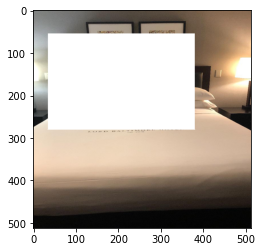

In [13]:
plt.imshow(masked_img)

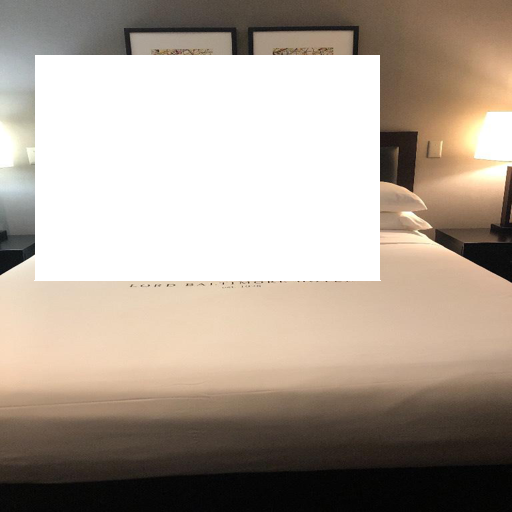

In [640]:
pil_image.fromarray((masked_img*255).astype(np.uint8))

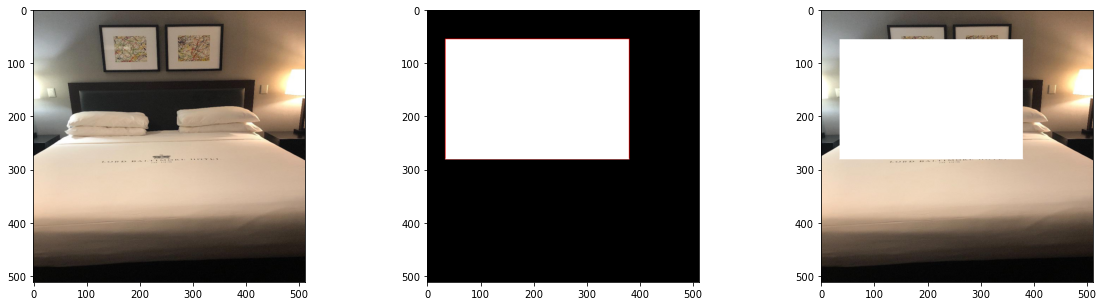

In [14]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask_img)
axes[2].imshow(masked_img)
plt.show()

# Test Image

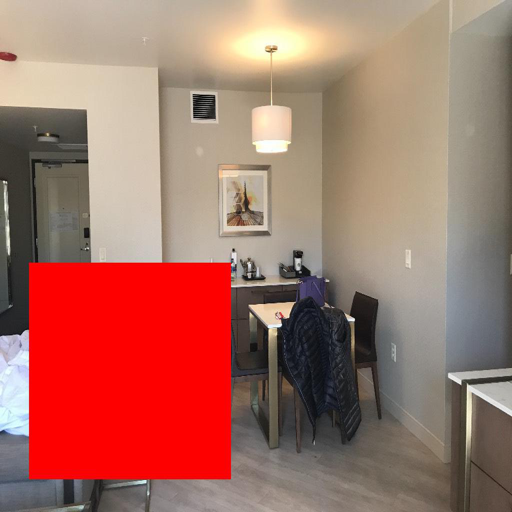

In [419]:
im = pil_image.open('test_img/abc.jpg')
imz= im.resize((512,512))
imz


(512, 512, 3)


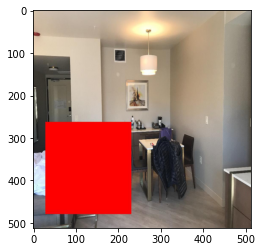

In [454]:
arim = np.array(imz)
print(arim.shape)
#arim = arim/255
#arim = np.where(arim==0,0,arim)
#print(np.unique(arim, return_counts=True))
#ier= pil_image.fromarray(arim)
#ier
plt.imshow(arim[:,:,:])

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras.layers import Input, Dense, ZeroPadding2D
from keras.models import Model

Using TensorFlow backend.


# #model

In [655]:
from libs.pconv_layer import PConv2D
shape=(512,512,3)
# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

tracking <tf.Variable 'p_conv2d_58/Variable:0' shape=(7, 7, 3, 8) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_59/Variable:0' shape=(5, 5, 8, 16) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_60/Variable:0' shape=(5, 5, 16, 32) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_61/Variable:0' shape=(3, 3, 32, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_62/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_63/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_64/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_65/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)        

In [656]:
output_img, o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([masked_imgq, mask_imgq])

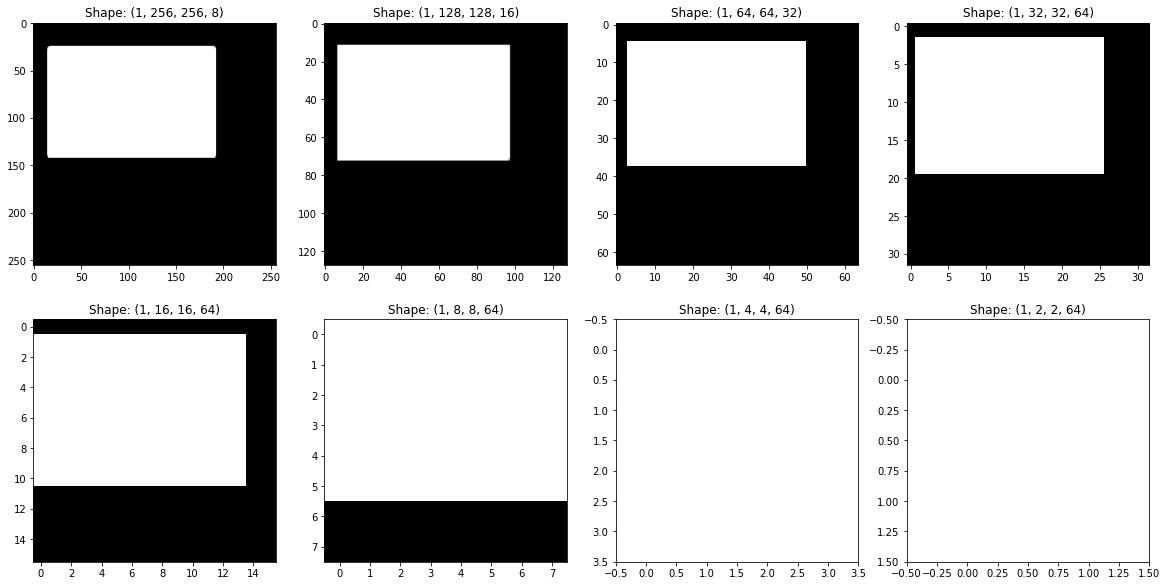

In [659]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 2], cmap = 'gray', vmin=0, vmax=1)
#axes[2][0].imshow(output_img[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

In [281]:
output_img.shape

(1, 2, 2, 64)

In [645]:
masked_imgq=masked_img.reshape(1,masked_img.shape[0],masked_img.shape[1],masked_img.shape[2])
mask_imgq=mask_img.reshape(1,mask_img.shape[0],mask_img.shape[1],mask_img.shape[2])
imgq = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
maskq.shape
imgq.shape


(1, 512, 512, 3)

In [16]:
from libs.pconv_model import PConvUnet

In [255]:
PConvUnet().summary()

2022-05-01 18:42:36.927845: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 18:42:36.930085: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_11/Variab

In [256]:
model = PConvUnet()

tracking <tf.Variable 'p_conv2d_17/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_18/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_19/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_20/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_21/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_22/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_23/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_24/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_25/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_26/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

In [306]:
generator =([masked_imgq,maskq],imgq)

## unet model try

In [17]:
import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda
from keras.layers.merge import Concatenate
from keras import backend as K
from libs.pconv_layer import PConv2D
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

In [18]:
def build_pconv_unet(train_bn=True):      

        # INPUTS
        inputs_img = Input((512, 512, 3), name='inputs_img')
        inputs_mask = Input((512, 512, 3), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask 

In [19]:
 model, inputs_mask = build_pconv_unet()

2022-05-04 16:49:50.540715: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 16:49:50.541697: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_11/Variab

In [20]:
def compile_pconv_unet(model, inputs_mask, lr=0.0002):
        model.compile(
            optimizer = Adam(lr=lr),
            loss=loss_total(inputs_mask),
            metrics=[PSNR]
        )

In [21]:
def PSNR(y_true, y_pred):
        """
        PSNR is Peek Signal to Noise Ratio, see https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        The equation is:
        PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
        
        Our input is scaled with be within the range -2.11 to 2.64 (imagenet value scaling). We use the difference between these
        two values (4.75) as MAX_I        
        """        
        #return 20 * K.log(4.75) / K.log(10.0) - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 
        return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 

In [22]:
    def loss_total(mask):
        """
        Creates a loss function which sums all the loss components 
        and multiplies by their weights. See paper eq. 7.
        """
        def loss(y_true, y_pred):

            # Compute predicted image with non-hole pixels set to ground truth
            y_comp = mask * y_true + (1-mask) * y_pred

            # Compute the vgg features. 
#             if self.vgg_device:
#                 with tf.device(self.vgg_device):
#                     vgg_out = self.vgg(y_pred)
#                     vgg_gt = self.vgg(y_true)
#                     vgg_comp = self.vgg(y_comp)
#             else:
#                 vgg_out = self.vgg(y_pred)
#                 vgg_gt = self.vgg(y_true)
#                 vgg_comp = self.vgg(y_comp)
            
            # Compute loss components
            l1 = loss_valid(mask, y_true, y_pred)
            l2 = loss_hole(mask, y_true, y_pred)
            #l3 = self.loss_perceptual(vgg_out, vgg_gt, vgg_comp)
           # l4 = self.loss_style(vgg_out, vgg_gt)
            #l5 = self.loss_style(vgg_comp, vgg_gt)
            #l6 = loss_tv(mask, y_comp)

            # Return loss function
            return l1 + 6*l2 

        return loss 

In [23]:
def loss_hole(mask, y_true, y_pred):
        """Pixel L1 loss within the hole / mask"""
        return l1((1-mask) * y_true, (1-mask) * y_pred)
    
def loss_valid(mask, y_true, y_pred):
    """Pixel L1 loss outside the hole / mask"""
    return l1(mask * y_true, mask * y_pred)

def loss_tv( mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = l1(P[:,:,1:,:], P[:,:,:-1,:])        
        return a+b
    
    

In [24]:
def l1(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")
    

In [25]:
compile_pconv_unet(model, inputs_mask)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 256, 256, 64 18880       inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           p_conv2d_1[0][0]           

In [30]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

Epoch 1/5
2/2 [==============================] - 18s 9s/step - loss: 1.1419 - PSNR: 10.8966


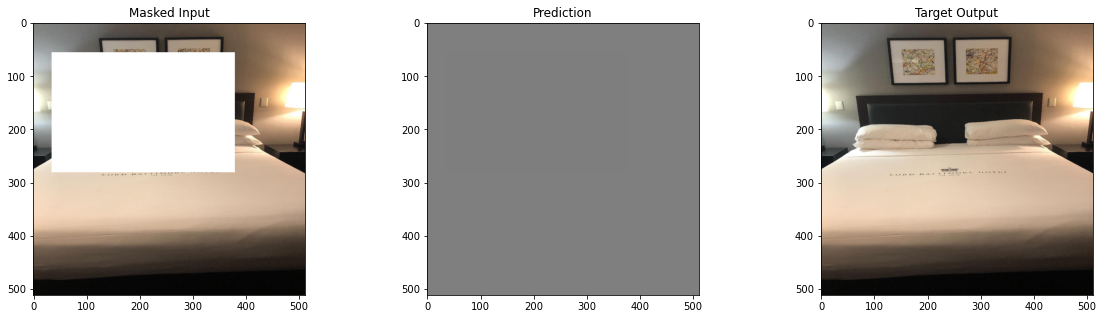

Epoch 2/5
2/2 [==============================] - 19s 10s/step - loss: 1.1419 - PSNR: 10.8969


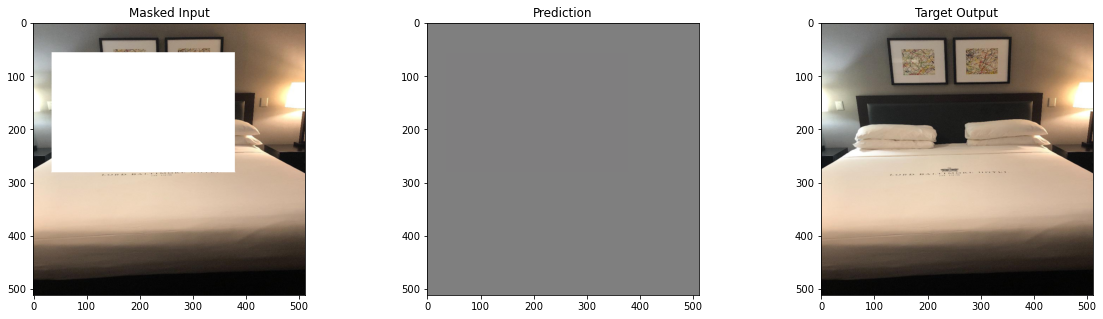

Epoch 3/5
2/2 [==============================] - 19s 9s/step - loss: 1.1419 - PSNR: 10.8973


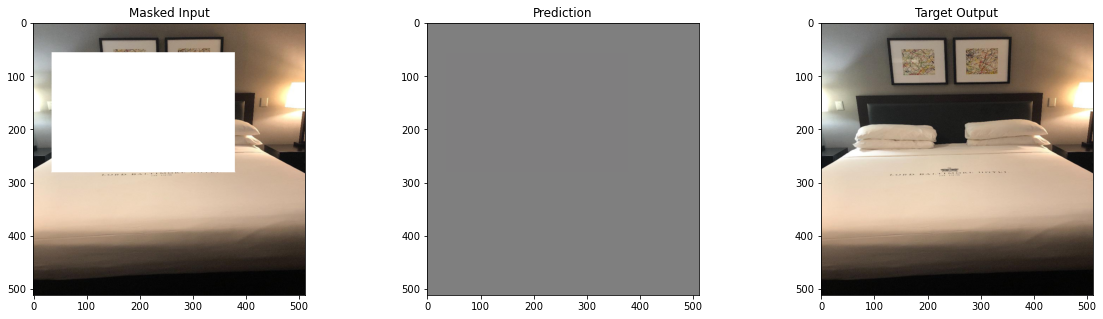

Epoch 4/5
2/2 [==============================] - 20s 10s/step - loss: 1.1418 - PSNR: 10.8977


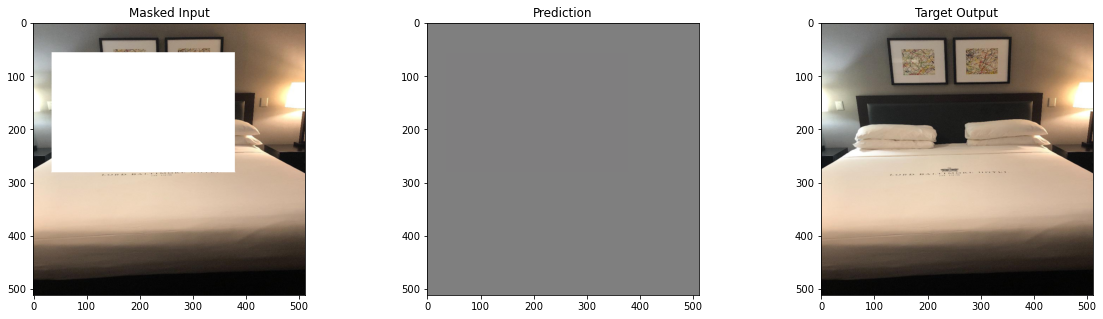

Epoch 5/5
2/2 [==============================] - 19s 10s/step - loss: 1.1418 - PSNR: 10.8980


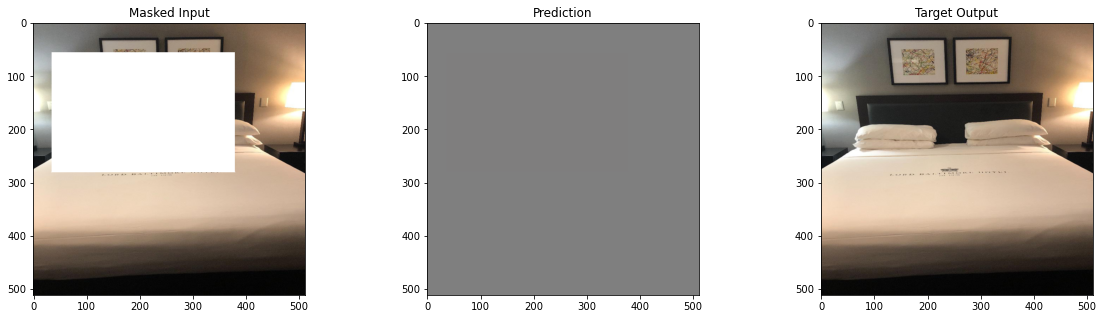

In [31]:
model.fit(x= [masked_list,mask_list],y =img_list, batch_size=len(img_list), epochs=5,callbacks=[ LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask_img,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )])

In [354]:
result = model.predict( [np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)])

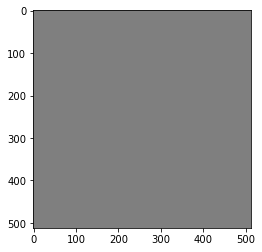

In [653]:
plt.imshow(result[0][:,:,:])

In [660]:
#pil_image.fromarray((result[0]*255).astype(np.uint8))

# data gen

In [661]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [662]:
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


generator = datagen.flow(x=img, batch_size=1)
generator

<generator object DataGenerator.flow at 0x7fa684c1a850>

In [669]:
#plt.imshow(generator.gi_frame)

In [27]:
#img_list=np.copy(img)
mask_list=np.zeros((2,512,512,3))
masked_list =np.zeros((2,512,512,3))
img_list= np.zeros((2,512,512,3))

for i in range(2):
    #img_list = 
    #img_list.append(img)
    #img_list = np.stack([img_list,img])
    img_list[i]=img
    mask_list[i] = mask_img
    masked_list[i] = masked_img
    
    #mask_list = np.stack([mask_list,mask_img])
    #masked_list = np.stack([masked_list,masked_img])
    #mask_list = mask_list.append(mask_img)
    
    #masked_list.append(masked_img)
    

In [28]:
img_list.shape

(2, 512, 512, 3)

In [44]:
mask_list.shape

(50, 512, 512, 3)

In [45]:
masked_list.shape

(50, 512, 512, 3)

In [51]:
newimg= np.array([img]).repeat(5,axis=0).reshape(-1,512,512,3)

In [52]:
newimg.shape

(5, 512, 512, 3)

In [53]:
len(img_list)

50